# SI Figure 8
## Spatial distribution of SWOT swaths

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import cartopy.io.shapereader as shpreader
from cartopy import geodesic
import xarray as xr
import numpy as np
import cmocean as cm
import os
import glob

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Function: load_bathymetry
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def load_bathymetry(zip_file_url):
    """
    Loads bathymetry data from a Natural Earth zip file containing shapefiles.

    Parameters
    ----------
    zip_file_url : str
        URL of the zip file containing bathymetry shapefiles.

    Returns
    -------
    depths : np.ndarray
        Sorted array of depth levels (from surface to bottom).
    shp_dict : dict
        Dictionary mapping depth levels (as strings) to their respective shapefile geometries.
    """
    # Import required libraries for downloading and extracting zip files
    import io
    import zipfile
    import requests

    # Check if bathymetry data is already downloaded
    if not os.path.exists("../ne_10m_bathymetry_all/"):
        print("Downloading bathymetry shapefiles...")
        # Download the zip file and extract its contents
        r = requests.get(zip_file_url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall("../ne_10m_bathymetry_all/")  # Extract files to the specified directory

    # Read all shapefiles in the extracted directory
    shp_dict = {}
    files = glob.glob('../ne_10m_bathymetry_all/*.shp')  # Get all shapefiles
    assert len(files) > 0, "No shapefiles found in the directory!"
    files.sort()  # Sort the files to process them in order

    # Extract depth levels from the filenames and load the geometries
    depths = []
    for f in files:
        # Extract depth value from the filename (e.g., "-2000" from "ne_10m_bathymetry_-2000.shp")
        depth = '-' + f.split('_')[-1].split('.')[0]
        depths.append(depth)

        # Load the shapefile using Cartopy's `shpreader`
        bbox = (-180, -90, 180, 90)  # Global bounding box (lon_min, lat_min, lon_max, lat_max)
        nei = shpreader.Reader(f, bbox=bbox)
        shp_dict[depth] = nei

    # Return depths (sorted from surface to bottom) and the shapefile dictionary
    depths = np.array(depths)[::-1]  # Reverse to get surface-to-bottom order
    return depths, shp_dict


# Load bathymetry shapefiles from Natural Earth repository
depths_str, shp_dict = load_bathymetry(
    'https://naturalearth.s3.amazonaws.com/' +
    '10m_physical/ne_10m_bathymetry_all.zip'
)

# Create a colormap for bathymetry depth levels
depths = depths_str.astype(int)  # Convert depth strings to integers
N = len(depths)  # Number of depth levels
nudge = 0.01  # Slight adjustment to bin edges
boundaries = [min(depths)] + sorted(depths + nudge)  # Bin edges for colormap
norm = matplotlib.colors.BoundaryNorm(boundaries, N)  # Normalize depth values
blues_cm = matplotlib.colormaps['Blues_r'].resampled(N)  # Use reversed "Blues" colormap
colors_depths = blues_cm(norm(depths))  # Map depth values to corresponding colors


In [34]:
# Physical constants (you might parameterize these)
f = -9.37e-5  # Coriolis parameter at ~40°S (s⁻¹)
g = 9.81      # gravitational acceleration (m/s²)
dx = dy = 1500  # grid spacing in m
dx_km = dx / 1000  # for plotting axis scale

base_path = "./tatsu_data"

# Load datasets
datasets = {
    'passID113': xr.open_dataset(f"{base_path}/cycle005_passID113.nc").compute(),
    'passID361': xr.open_dataset(f"{base_path}/cycle005_passID361.nc").compute(),
    'passID488': xr.open_dataset(f"{base_path}/cycle005_passID488.nc").compute(),
    'passID557': xr.open_dataset(f"{base_path}/cycle005_passID557.nc").compute(),
    'passID572': xr.open_dataset(f"{base_path}/cycle005_passID572.nc").compute(),

    'passID016': xr.open_dataset(f"{base_path}/cycle006_passID016.nc").compute(),
    'passID070': xr.open_dataset(f"{base_path}/cycle006_passID070.nc").compute(),
    'passID128': xr.open_dataset(f"{base_path}/cycle006_passID128.nc").compute()
}

passes = ["113","361","488","557","572","016","070","128"]
cycles = ["005","005","005","005","005","006","006","006"]

passID113
passID361
passID488
passID557
passID572
passID016
passID070
passID128


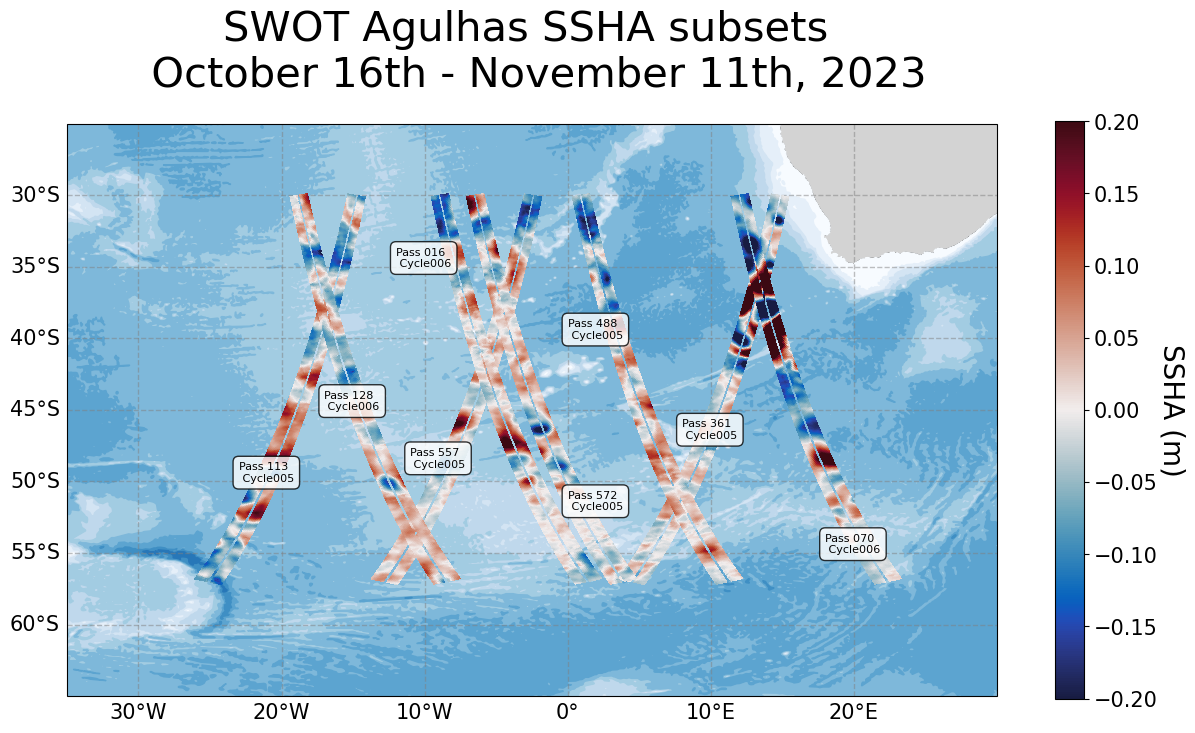

In [51]:
# --- Projection setup ---
projection = ccrs.PlateCarree()

# --- Create plot ---
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=projection)
ax.set_global()

# Add base features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
#ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
for j, depth_str in enumerate(depths_str):
    ax.add_geometries(shp_dict[depth_str].geometries(),
                      crs=ccrs.PlateCarree(),
                      color=colors_depths[j])

# --- Create and plot rectangle ---
# Create rectangle in PlateCarree (lon/lat) coordinates
rect = box(lon_min, lat_min, lon_max, lat_max)

label_locs = [[-23,-50], # 0
              [8,-47], # 1
              [0,-40], # 2
              [-11,-49], # 3
              [0,-52], # 4
              [-12,-35], # 5
              [18,-55], # 6
              [-17,-45], # 7
             ]
names = [f"Pass {passes[j]} \n Cycle{cycles[j]}" for j in range(len(passes))]


for i, key in enumerate(datasets):
    ds = datasets[key]
    print(key)
    im = ax.pcolor(ds.longitude[::2,::2],ds.latitude[::2,::2],ds.ssha_filtered[::2,::2]-ds.ssha_filtered[::2,::2].mean(), 
              transform=ccrs.PlateCarree(),
              cmap=cm.cm.balance,vmin=-0.2,vmax=0.2,
              zorder=20)
    #print(ds.longitude[-6,-6].values, ds.latitude[-6,-6].values)
    #ax.plot(ds.longitude[-6,-6].values, ds.latitude[-6,-6].values, 'ro', transform=ccrs.PlateCarree())
    ax.text(label_locs[i][0], label_locs[i][1], f"{names[i]}", transform=ccrs.PlateCarree(), fontsize=8, zorder=50, 
           bbox=dict(facecolor='white', edgecolor='k', boxstyle='round,pad=0.5', alpha=0.8,))

cbar = fig.colorbar(im,ax=ax,shrink=.5)
cbar.set_label("SSHA (m)", fontsize=20, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=15)
# Mark the rectangle center

ax.set_ylim(-65, -25.)
ax.set_xlim(-35, 30)
ax.set_ylabel(r"Latitude $(^{o})$", fontsize=20)
ax.set_xlabel(r"Longitude $(^{o})$", fontsize=20)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'fontsize': 15}
gl.ylabel_style = {'fontsize': 15}
gl.top_labels = False
gl.right_labels = False

ax.set_title("SWOT Agulhas SSHA subsets \n October 16th - November 11th, 2023", fontsize=30, y=1.05)
plt.show()
